# Init

https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from src.dataset import DatasetMix,DatasetFix
from src.UNet import UNet
from src.utils import get_output_wav,train,infer

import matplotlib.pyplot as plt 
import IPython.display as ipd

# Data download  

## 데이터셋  

**_[TODO]구글 드라이브에 저장된 데이터셋 다운로드_**

+ train    
    매 학습시 새로 합성하는 on-fly로 진행하기 때문에 clean, noise 파일로 구성
+ dev  
    train,eval과 겹치지 않는 데이터로 합성된 noisy 데이터  
+ eval  
    dev,eval과 겹치지 않는 데이터로 합성된 noisy 데이터
    
## clean 데이터
+ [AI HUB 한국어 음성 데이터](https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=123)  
2명의 화자가 특정 주제에 대해서 자유롭게 발화하는 데이터셋  

## noise 데이터
+ [CHiME4 background noises](https://spandh.dcs.shef.ac.uk/chime_challenge/CHiME4/data.html#Backgrounds)의 STR  
특정 장소(STR : 길가)에서 장시간 녹음한 잡음 데이터  


In [3]:
from os.path import exists

if not exists("SE_dataset.tar") :
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='1eeNuoY_z8e2g2e0gjC-tlvTppy3XRUcR -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="1eeNuoY_z8e2g2e0gjC-tlvTppy3XRUcR -O SE_dataset.tar && rm -rf /tmp/cookies.txt
    !tar -xf SE_dataset.tar

# Dataset 

## train 데이터 합성  

개별 clean wav에서 1초 길이를 샘플링, 하나의 긴 noise 파일에서 1초 길이를 샘플링 한 뒤  
SNR 0dB ~ 10dB 로 랜덤하게 합성   

In [4]:
dataset_train = DatasetMix("clean_train","noise_train.wav")
dataset_dev = DatasetFix("dev")
dataset_eval = DatasetFix("eval")

Dataset:: 1000 clean data from clean_train | noise : (29716608,)  
Dataset:: 100 clean data from dev
Dataset:: 100 clean data from eval


# Model Implementation

## UNet

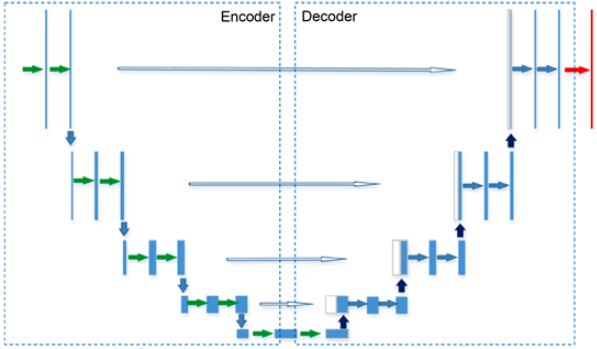  

+ Input  

TODO mag,phase 설명  
TODO 왜 mag만 쓰는가  

+ Output  

TODO mask 설명

**_[TODO]Encoder,Decoder 구현_**  
**_[Option]Residual Path,bottleneck 구현_**

## Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride, 
                 padding):
        super().__init__()
      
        self.conv = nn.Conv2d(in_channels, 
                              out_channels, 
                              kernel_size=kernel_size, 
                              stride=stride)
        self.norm = nn.BatchNorm2d(out_channels)
        self.acti = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.acti(x)
        return x

encoders=[]
# in_ch, out_ch,kernel,stride, padding
encoders.append(Encoder(1,32,(7,5),(2,2),(2,1)))
encoders.append(Encoder(32,32,(5,7),(2,2),(0,0)))
encoders.append(Encoder(32,32,(5,3),(2,2),(0,0)))
print(len(encoders))

3


## Decoder

In [6]:
class Decoder(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels,
                 kernel_size, 
                 stride, 
                 output_padding,
                 padding=(0, 0)):
        super().__init__()
       
        self.transconv = nn.ConvTranspose2d(
            in_channels, 
            out_channels, 
            kernel_size=kernel_size,
            stride=stride, 
            output_padding=output_padding,
            padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.acti = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.transconv(x)
        x = self.norm(x)
        x = self.acti(x)
        return x
    
decoders=[]
decoders.append(Decoder(32,32,kernel_size=(5,4),stride=(2,2),padding=(0,0),output_padding=(0,0)))
decoders.append(Decoder(32+32,32,kernel_size=(5,6),stride=(2,2),padding=(0,0),output_padding=(1,1)))
decoders.append(Decoder(32+32,1,kernel_size=(7,6),stride=(2,2),padding=(0,0),output_padding=(0,0)))
print(len(decoders))

3


## Optional

### Bottleneck

### Residual Path

## UNet

**_[TODO]모델 정상 동작 확인_**

In [7]:
model = UNet(encoders,decoders)
x = torch.rand(1,1,257,126)
y = model(x)
print(y.shape)

torch.Size([1, 1, 257, 126])


# SDR(Signal-to-Distortion Ratio) Loss

+ Venkataramani, Shrikant, Jonah Casebeer, and Paris Smaragdis. "Adaptive front-ends for end-to-end source separation." Proc. NIPS. 2017.  
+ Choi, Hyeong-Seok, et al. "Phase-aware speech enhancement with deep complex u-net." International Conference on Learning Representations. 2018.  

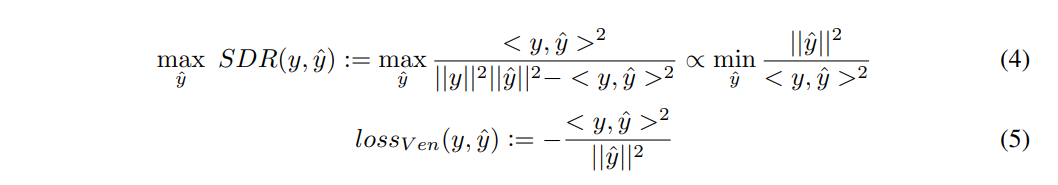

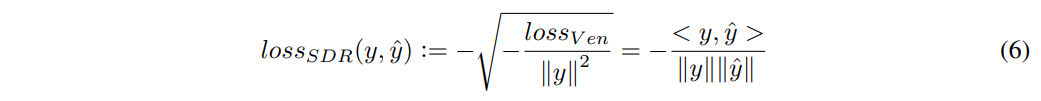

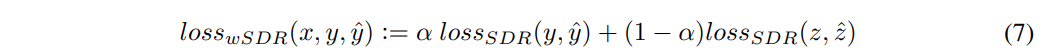

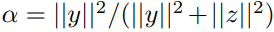 or 임의의 Weight 

## TODO  

SDR에 관한 수학적 이야기 

**_[TODO]wSDRLoss 구현_**

$$ \max_{\hat{y}}$$

In [17]:
# mSDR == CosineSimilarity
# mSDR is not Scale Invariant
def mSDRLoss(output,target, eps=1e-7):
    # Modified SDR loss, <x, x`> / (||x|| * ||x`||) : L2 Norm.
    # Original SDR Loss: <x, x`>**2 / <x`, x`> (== ||x`||**2)
    #  > Maximize Correlation while producing minimum energy output.
    #xx = torch.dot(output,output)
    #xy = torch.dot(output,target)

    #return xx/(xy**2)
    correlation = torch.sum(target * output, dim=1)
    energies = torch.norm(target, p=2, dim=1) * torch.norm(output, p=2, dim=1)

    return torch.mean(-(correlation / (energies + eps)))

def wSDRLoss(output,noisy,target,alpha=0.5,eps=2e-7):
        noise = noisy - target
        noise_est = noisy - output

        wSDR = alpha * mSDRLoss(output,target,eps=eps) + (1-alpha)*mSDRLoss(noise_est,noise,eps=eps)
        return wSDR
    

# Train

**_[TODO]학습 진행_**

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

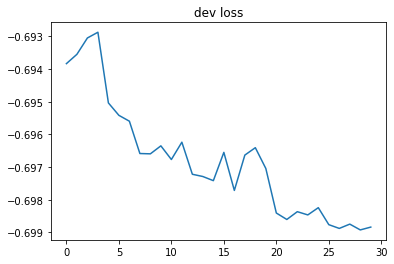

In [18]:
from src.utils import train
train(model,dataset_train,dataset_dev,wSDRLoss)

# Evaluation

**_[TODO]목표 수치 달성_**

+ clean

+ noisy

+ estim

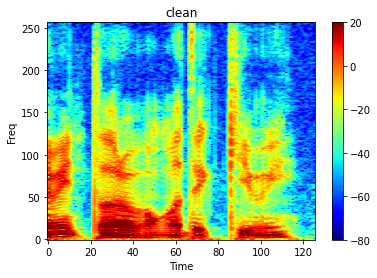

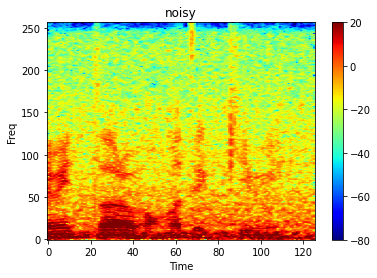

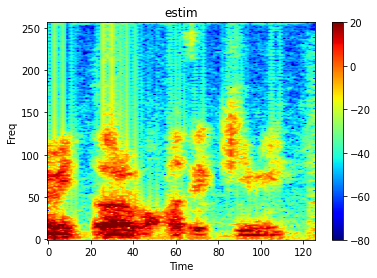

In [19]:
from src.utils import infer,plot_spec
model.eval()
with torch.no_grad():
    clean,noisy,estim = infer(dataset_eval[5],model)
    
    ipd.display(ipd.Markdown('+ clean'))
    display(ipd.Audio(clean,rate=16000))
    
    plot_spec(clean,"clean")
    plot_spec(noisy,"noisy")
    plot_spec(estim,"estim")
    
    ipd.display(ipd.Markdown('+ noisy'))
    display(ipd.Audio(noisy,rate=16000))
    
    ipd.display(ipd.Markdown('+ estim'))
    display(ipd.Audio(estim,rate=16000))